In [66]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image

https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset

In [67]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [68]:
ds_url = 'https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset'
od.download(ds_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ebadsayed
Your Kaggle Key: ··········


100%|██████████| 3.24G/3.24G [02:43<00:00, 21.2MB/s]


In [72]:
data_dir = './a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

In [73]:
import os
os.listdir(data_dir)

['Hourse Mackerel',
 'Gilt-Head Bream',
 'Red Sea Bream',
 'Trout',
 'Segmentation_example_script.m',
 'Black Sea Sprat',
 'README.txt',
 'Red Mullet',
 'Shrimp',
 'Sea Bass',
 'Striped Red Mullet',
 'license.txt']

In [74]:
len(data_dir)

54

In [75]:
from torchvision.datasets import ImageFolder

In [76]:
ds = ImageFolder(data_dir)

In [77]:
len(ds)

18000

In [78]:
# from google.colab import drive
# drive.mount('/content/drive')

In [79]:
ds[0]

(<PIL.Image.Image image mode=RGB size=590x445 at 0x7F39232B02E0>, 0)

In [80]:
ds.classes

['Black Sea Sprat',
 'Gilt-Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

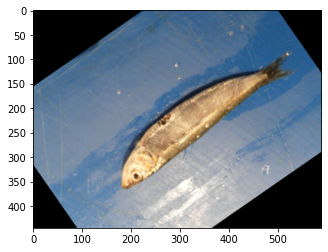

In [82]:
img, label = ds[0]
plt.imshow(img)

In [83]:
import torchvision.transforms as tt

ds = ImageFolder(data_dir, tt.Compose([tt.Resize(64),
                                      tt.RandomCrop(64),
                                      tt.ToTensor()]))

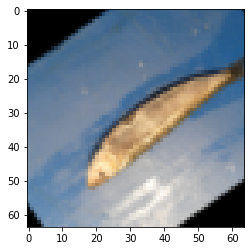

In [84]:
img, label = ds[0]
plt.imshow(img.permute((1,2,0)))

In [85]:
val_pct = 0.1                     # Validation Percentage
val_size = int(val_pct * len(ds)) # Validation Size
train_size = len(ds) - val_size
train_size, val_size

(16200, 1800)

In [86]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(ds, [train_size, val_size])
len(train_ds), len(val_ds)

(16200, 1800)

In [87]:
batch_size = 32

from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

val_dl = DataLoader(val_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [88]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

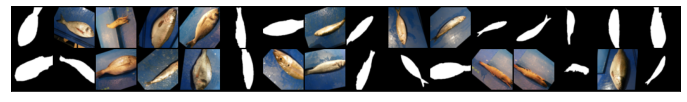

In [89]:
show_batch(train_dl)

In [90]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [91]:
torch.cuda.is_available()

True

In [92]:
device = get_default_device()
device

device(type='cuda')

In [93]:
img, label = ds[0]
img.device

device(type='cpu')

In [94]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [95]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [96]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):    
      # Calculate Loss for a batch of Training data
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):       
      # Calculate Loss & Accuracy for a batch of Validation data
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [97]:
@torch.no_grad()
def evaluate(model, val_loader):
  # Evaluates the model's Performance on the Validation dataset
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [98]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input : 128 x 3 x 64 x 64
        
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [99]:
model = to_device(ResNet9(3,len(ds.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [100]:
model.conv1[0].weight.device

device(type='cuda', index=0)

In [101]:
for batch in train_dl:
  images, labels = batch
  print('images.shape', images.shape)
  print('images.device', images.device)
  preds = model(images)
  print('preds.shape', preds.shape)
  break

images.shape torch.Size([32, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([32, 9])


In [102]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 2.1975159645080566, 'val_acc': 0.11184210330247879}]

In [103]:
history += fit(3, 0.001, model, train_dl, val_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.3446, val_loss: 1.2353, val_acc: 0.5203
Epoch [1], train_loss: 0.7710, val_loss: 0.6662, val_acc: 0.7533
Epoch [2], train_loss: 0.6058, val_loss: 0.6654, val_acc: 0.7489


In [104]:
history += fit(3, 0.0001, model, train_dl, val_dl) # Using torch.optim.SGD which is the default

Epoch [0], train_loss: 0.5000, val_loss: 0.3935, val_acc: 0.8547
Epoch [1], train_loss: 0.4626, val_loss: 0.3810, val_acc: 0.8547
Epoch [2], train_loss: 0.4596, val_loss: 0.3730, val_acc: 0.8575


In [105]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

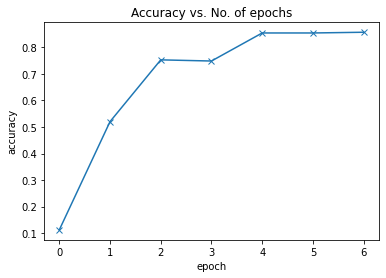

In [106]:
plot_accuracies(history)

In [107]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

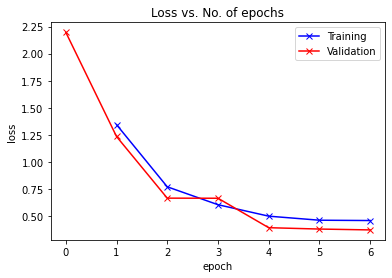

In [108]:
plot_losses(history)

In [109]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [110]:
def predictions(num):
  img, label = val_ds[num]
  plt.imshow(img.permute(1,2,0))
  pred = predict_image(img, model, ds.classes)
  print('Target :', ds.classes[label])
  print('Prediction :', pred)

Target : Sea Bass
Prediction : Sea Bass


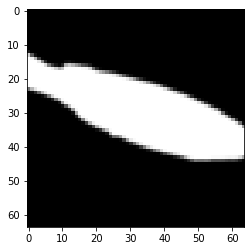

In [111]:
predictions(0)

Target : Trout
Prediction : Trout


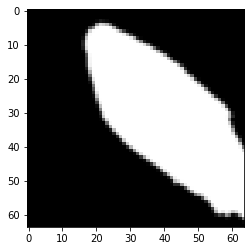

In [112]:
predictions(1)

Target : Sea Bass
Prediction : Sea Bass


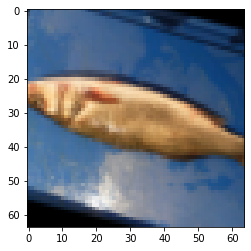

In [113]:
predictions(2)

Target : Red Mullet
Prediction : Red Mullet


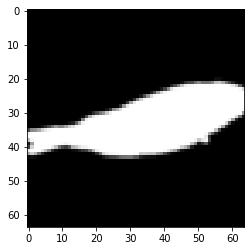

In [114]:
predictions(3)

Target : Shrimp
Prediction : Shrimp


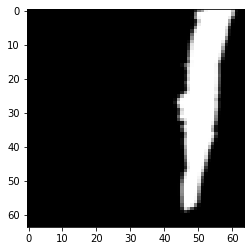

In [115]:
predictions(4)

Target : Hourse Mackerel
Prediction : Hourse Mackerel


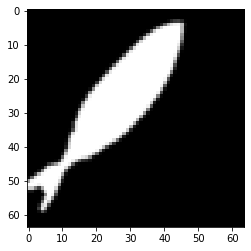

In [116]:
predictions(5)

Target : Sea Bass
Prediction : Sea Bass
Target : Trout
Prediction : Trout
Target : Sea Bass
Prediction : Sea Bass
Target : Red Mullet
Prediction : Sea Bass
Target : Shrimp
Prediction : Shrimp
Target : Hourse Mackerel
Prediction : Hourse Mackerel
Target : Sea Bass
Prediction : Sea Bass
Target : Sea Bass
Prediction : Sea Bass
Target : Striped Red Mullet
Prediction : Striped Red Mullet
Target : Trout
Prediction : Trout
Target : Red Sea Bream
Prediction : Gilt-Head Bream
Target : Red Sea Bream
Prediction : Red Sea Bream
Target : Shrimp
Prediction : Shrimp
Target : Trout
Prediction : Trout
Target : Trout
Prediction : Trout
Target : Red Mullet
Prediction : Red Mullet
Target : Sea Bass
Prediction : Sea Bass
Target : Striped Red Mullet
Prediction : Striped Red Mullet
Target : Gilt-Head Bream
Prediction : Gilt-Head Bream
Target : Shrimp
Prediction : Shrimp
Target : Red Mullet
Prediction : Red Mullet
Target : Striped Red Mullet
Prediction : Striped Red Mullet
Target : Sea Bass
Prediction : Sea B

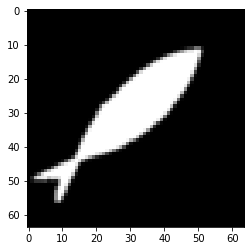

In [117]:
for i in range(0,200):
  predictions(i)

In [118]:
!pip install jovian
import jovian
jovian.commit()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [119]:
jovian.commit

<function jovian.utils.commit.commit(message=None, files=[], outputs=[], environment=None, privacy='auto', filename=None, project=None, new_project=None, git_commit=False, git_message='auto', require_write_access=False, **kwargs)>